# San Diego vs global temperature history

## Objective
Obtain and present historical temperatures for San Diego vs. the Earth

## Description 
Temperature data is obtained from the "Climate Change: Earth Surface Temperature Data" dataset, at Kaggle.com. This dataset comprises the following files:
* GlobalLandTemperaturesByCity.csv (532 MB, 800,000 rows, 3000 cities)
* GlobalLandTemperaturesByCountry.csv (1.1 MB, 570,000 rows, 243 countries )
* GlobalLandTemperaturesByMajorCity.csv (0.7 MB, 240,000 rows, 101 cities )
* GlobalLandTemperaturesByState.csv -- states in different countries (1.5 MB, 645,000 rows, 242 states)

This analysis will use the temperature data from the GlobalLandTemperaturesByCountry.csv file, along with San Diego data from GlobalLandTemperaturesByCity.csv. Countries are selected to represent different geographical locations around the world, and as to whether they are sufficiently advanced to record accurate and reliable temperature data during the last 170 years:
* San Diego
* USA, North America
* Argentina, southern South America
* Venezuela, northern South America
* Australia, Australia
* Egypt, northern Africa
* Kenya, central Africa
* Poland, north-eastern Europe
* Sweden, north-western Europe
* Japan, north-eastern Asia
* India, south-central Asia

The available data for each country is the average monthly temperature from 1743 to 2013. Most countries do not report temperatures until the early-1800's. Sweden and Poland report temperatures from 1744. San Diego data starts on 1849.

Incidentally, there is no temperature data for the years 1746 to 1749.

**To collapse the data, plots will use yearly averages.**

**Years before the San Diego data (1849) will be dropped.**

## Procedure
1. Ingest temperature vs year data for the above select countries from GlobalLandTemperaturesByCountry.csv
2. Ingest temperature vs year data for San Diego from GlobalLandTemperaturesByCity.csv
 * Because GlobalLandTemperaturesByCity.csv is larger than the normal git file size limit, a new file will be created that only contains data for San Diego.
3. Concatenate the select country and San Diego data
4. Ascertain whether the temperature data needs cleaning.  Verdict:  Use as is.
5. Calculate the mean temperature for each year (the above csv files contain temperature data for each month)
6. Build a pivot table with Year and country columns and temperature values
7. Build Fig 1 by plotting the yearly temperatures for the 10 countries and San Diego
8. Use Fig 1 to identify any outlier temperatures and set them to the average temperature
9. Build Fig 2 normalizing Fig 1 by subtracting the average temperature
10. Combine the country temperatures into one series.  The temperature is the average of all countries
    * The average calculation returns a NaN if any country as an NaN for a given year.  To handle this, all NaN values are replaced with zero.
11. Build Fig 3 by plotting the yearly temperatures for San Diego and the combined country average
12. Build Fig 4 by using a rolling average (window = 10 years) on Fig 3.
13. Build Fig 5 by modifying Fig 3 to be a scatter plot with linear regression lines and t-stats.

## Obtain historical temperature data

In [1]:
%matplotlib inline

# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import linregress, ttest_ind

In [2]:
# import the country data
folder_name = "resources/climate-change-earth-surface-temperature-data/"
country_file_name = "GlobalLandTemperaturesByCountry.csv"
raw_data = pd.read_csv(folder_name + country_file_name)
raw_data

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland
...,...,...,...,...
577457,2013-05-01,19.059,1.022,Zimbabwe
577458,2013-06-01,17.613,0.473,Zimbabwe
577459,2013-07-01,17.000,0.453,Zimbabwe
577460,2013-08-01,19.759,0.717,Zimbabwe



### The country data is filtered by the above mentioned countries.


In [3]:
country_data = raw_data.loc[
    (raw_data['Country'] == 'United States') | 
    (raw_data['Country'] =='Argentina') |
    (raw_data['Country'] =='Venezuela') |
    (raw_data['Country'] =='Australia') |
    (raw_data['Country'] =='Egypt') |
    (raw_data['Country'] =='India') |
    (raw_data['Country'] =='Kenya') |
    (raw_data['Country'] =='Poland') |
    (raw_data['Country'] =='Sweden') |
    (raw_data['Country'] =='Japan')
]
country_data

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
25466,1855-05-01,10.745,1.499,Argentina
25467,1855-06-01,6.995,2.073,Argentina
25468,1855-07-01,6.901,1.568,Argentina
25469,1855-08-01,9.097,1.412,Argentina
25470,1855-09-01,11.316,1.384,Argentina
...,...,...,...,...
564611,2013-05-01,26.253,0.511,Venezuela
564612,2013-06-01,25.674,0.358,Venezuela
564613,2013-07-01,25.449,0.332,Venezuela
564614,2013-08-01,25.626,0.466,Venezuela


### Import the San Diego data, from a different file

In [4]:
# import the San Diego data
san_diego_file_name = "GlobalLandTemperaturesByCity.csv"
raw_data_san_diego = pd.read_csv(folder_name + san_diego_file_name)    # folder_name from above
san_diego_data = raw_data_san_diego.loc[raw_data_san_diego['City'] == 'San Diego'] 

# replace the old "GlobalLandTemperaturesByCity.csv (which is 532 MB) with one that only contains San Diego data
san_diego_data.to_csv(folder_name + san_diego_file_name, index=False)

# display
san_diego_data

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,13.116,2.586,San Diego,United States,32.95N,117.77W
1,1849-02-01,12.656,1.882,San Diego,United States,32.95N,117.77W
2,1849-03-01,13.551,2.035,San Diego,United States,32.95N,117.77W
3,1849-04-01,14.146,2.805,San Diego,United States,32.95N,117.77W
4,1849-05-01,13.543,1.882,San Diego,United States,32.95N,117.77W
...,...,...,...,...,...,...,...
1972,2013-05-01,17.635,0.445,San Diego,United States,32.95N,117.77W
1973,2013-06-01,18.632,0.338,San Diego,United States,32.95N,117.77W
1974,2013-07-01,19.929,0.367,San Diego,United States,32.95N,117.77W
1975,2013-08-01,20.076,0.522,San Diego,United States,32.95N,117.77W


### Combine the San Diego data with select country data. This requires dropping country data that precedes the San Diego data (1849) and culling the columns of each data frame so that they match.

In [5]:
# drop the country data that precedes 1849
country_data_after_1848 = country_data.drop(country_data.loc[country_data['dt']<"1849-01-01"].index)

# rename the 'City' column of san_diego_data and the 'Country' column of country_data_after_1848 to 
# be 'City_Country'
san_diego_data_renamed = san_diego_data.rename(columns = {'City':'City_Country'})
country_data_renamed = country_data_after_1848.rename(columns = {'Country':'City_Country'})

# reduce the two data frames to the core set of common columns
common_columns = ['dt', 'AverageTemperature', 'City_Country']
country_data_reduced = country_data_renamed[common_columns]
san_diego_data_reduced = san_diego_data_renamed[common_columns]

# concatenate the two data frames into one
temp_df_concat = pd.concat([san_diego_data_reduced, country_data_reduced])

# reset the index of the concatenated data frame
temp_df_concat.reset_index(inplace=True)
temp_df_concat

,index,dt,AverageTemperature,City_Country
0,0,1849-01-01,13.116,San Diego
1,1,1849-02-01,12.656,San Diego
2,2,1849-03-01,13.551,San Diego
3,3,1849-04-01,14.146,San Diego
4,4,1849-05-01,13.543,San Diego
...,...,...,...,...
21612,564611,2013-05-01,26.253,Venezuela
21613,564612,2013-06-01,25.674,Venezuela
21614,564613,2013-07-01,25.449,Venezuela
21615,564614,2013-08-01,25.626,Venezuela


### Cleaning the data involves dropping rows that contain invalid temperatures

In [6]:
# find max and min temperatures
max_temp = temp_df_concat['AverageTemperature'].max()
min_temp = temp_df_concat['AverageTemperature'].min()
print(f"The max temp is {max_temp}")
print(f"The min temp is {min_temp}")

# detect NaN values by counting the number of entries in each column
temp_df_concat_count = temp_df_concat.count()
temp_df_concat_count

The max temp is 32.591
The min temp is -15.817


index                 21617
dt                    21617
AverageTemperature    21286
City_Country          21617
dtype: int64

### The above analysis shows that the only problem is missing temperature data. How many rows are affected?Anyway, those rows will be kept because that may be useful for plotting.

In [7]:
num_rows = temp_df_concat['index'].count()
num_empty_rows = num_rows - temp_df_concat['AverageTemperature'].count()
percent_empty_rows = 100 * (num_empty_rows / num_rows)
print(f"{num_empty_rows} out of {num_rows} rows ({percent_empty_rows} %) have missing temperature data")

331 out of 21617 rows (1.5312022944904473 %) have missing temperature data


### The data frame will be grouped by year, then the median temp for that year calculated. This can then be used for a pivot table that has city_country columns

In [8]:
# add a year column
temp_df_concat['Year'] = temp_df_concat["dt"].str.split("-").str[0]

# reorder data frame columns, and drop dt column, which is replaced with Year
columns = ['Year', 'City_Country', 'AverageTemperature']
temp_df_years = temp_df_concat[columns]

# create groupby, which will be used for averaging the monthly temperatures for each year
temp_group = temp_df_years.groupby(['Year', 'City_Country'])
temp_yearly_mean = temp_group.mean()

In [9]:
# create a pivot table for the temps
temp_yearly_mean_pivot = pd.pivot_table(temp_yearly_mean, index=["Year"], columns=["City_Country"])
temp_yearly_mean_pivot

AverageTemperature                                              \
City_Country          Argentina  Australia      Egypt      India      Japan   
Year                                                                          
1849                        NaN        NaN  22.243500  23.224250  11.605000   
1850                        NaN        NaN  21.808667  23.504583  11.116000   
1851                        NaN        NaN  22.358917  23.485167  11.117583   
1852                        NaN  20.188500  22.324667  23.378333  11.117833   
1853                        NaN  20.958250  22.762833  23.665417  11.257667   
...                         ...        ...        ...        ...        ...   
2009                  15.534417  22.690583  23.735000  25.146667  12.933833   
2010                  15.078833  22.078167  25.151917  25.050833  13.215583   
2011                  15.339667  21.767000  23.331417  24.415583  12.737750   
2012                  15.689000  22.024500  23.770917  24.640833  12.565667   
2013                  14.457125  22.142875  24.505250  25.413250  12.964750   

                                                                      \
City_Country      Kenya    Poland  San Diego    Sweden United States   
Year                                                                   
1849                NaN  6.511583  16.030167  1.553333      8.129167   
1850          23.366545  6.963000  15.553917  1.770917      8.248333   
1851                NaN  7.452167  15.662583  2.522250      8.657500   
1852                NaN  7.765250  16.063583  2.319750      8.183083   
1853                NaN  6.583083  16.687667  2.190833      8.459917   
...                 ...       ...        ...       ...           ...   
2009          25.228083  8.652917  17.031250  3.502417      9.137083   
2010          24.961250  7.621417  16.192167  1.658500      9.505583   
2011          24.965750  8.951667  16.255750  4.518750      9.549917   
2012          24.925417  8.537750  17.203583  2.972833     10.261083   
2013          24.935250  9.257875  17.180778  4.199750     11.297111   

                         
City_Country  Venezuela  
Year                     
1849          24.504083  
1850          24.539167  
1851          24.605250  
1852          24.491583  
1853          24.623083  
...                 ...  
2009          26.084917  
2010          26.150250  
2011          25.677333  
2012          25.688583  
2013          25.912875  

[165 rows x 11 columns]

## Present the historical temperature data

### Create a simple line plot ("the first plot") for the temperatures

In [10]:
# define the axes for the first plot, Fig 1
beginning_year = 1849
ending_year = 2013

year_axis = np.arange(beginning_year, ending_year + 1)
Argentina_temp_axis = temp_yearly_mean_pivot['AverageTemperature', "Argentina"].values
Australia_temp_axis = temp_yearly_mean_pivot['AverageTemperature', "Australia"].values
Egypt_temp_axis = temp_yearly_mean_pivot['AverageTemperature', "Egypt"].values
India_temp_axis = temp_yearly_mean_pivot['AverageTemperature', "India"].values
Japan_temp_axis = temp_yearly_mean_pivot['AverageTemperature', "Japan"].values
Kenya_temp_axis = temp_yearly_mean_pivot['AverageTemperature', "Kenya"].values
Poland_temp_axis = temp_yearly_mean_pivot['AverageTemperature', "Poland"].values
San_Diego_temp_axis = temp_yearly_mean_pivot['AverageTemperature', "San Diego"].values
Sweden_temp_axis = temp_yearly_mean_pivot['AverageTemperature', "Sweden"].values
United_States_temp_axis = temp_yearly_mean_pivot['AverageTemperature', "United States"].values
Venezuela_temp_axis = temp_yearly_mean_pivot['AverageTemperature', "Venezuela"].values

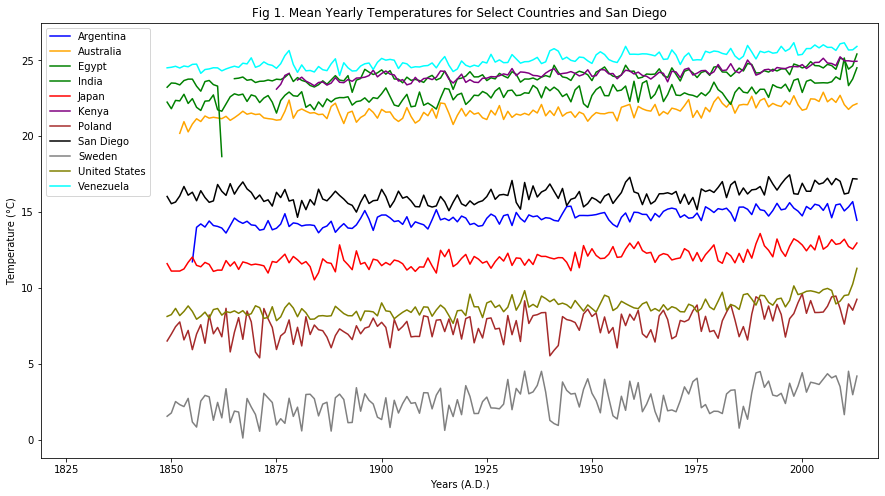

In [11]:
# plot the temperatures for Fig 1
plt.figure(num=0,figsize=(15, 8))
plt.plot(year_axis, Argentina_temp_axis, color="blue", label="Argentina")
plt.plot(year_axis, Australia_temp_axis, color="orange", label="Australia")
plt.plot(year_axis, Egypt_temp_axis, color="green", label="Egypt")
plt.plot(year_axis, India_temp_axis, color="green", label="India")
plt.plot(year_axis, Japan_temp_axis, color="red", label="Japan")
plt.plot(year_axis, Kenya_temp_axis, color="purple", label="Kenya")
plt.plot(year_axis, Poland_temp_axis, color="brown", label="Poland")
plt.plot(year_axis, San_Diego_temp_axis, color="black", label="San Diego")
plt.plot(year_axis, Sweden_temp_axis, color="gray", label="Sweden")
plt.plot(year_axis, United_States_temp_axis, color="olive", label="United States")
plt.plot(year_axis, Venezuela_temp_axis, color="cyan", label="Venezuela")

# Place a legend on the chart in what matplotlib believes to be the "best" location
plt.legend(loc="best")

# move the graph to the left to make room for the legend
plt.xlim(beginning_year - 30, ending_year + 5)

plt.title("Fig 1. Mean Yearly Temperatures for Select Countries and San Diego")
plt.xlabel("Years (A.D.)")
plt.ylabel("Temperature (°C)")

# Save the Figure
plt.savefig("images/Fig 1.png")

#### The above shows three outliers, India at year ~ 1860, Argentina at year ~ 1855, and United States as year ~ 2013. So these values will be set to the average temperature for that country, over the year range.

In [12]:
# identify the object type for the above temperature axis; this will determine the method to be used 
# to set the outlier values (Pandas is different from Numpy)
print(f"The India_temp_axis is a {type(India_temp_axis)} object")

The India_temp_axis is a <class 'numpy.ndarray'> object


In [13]:
# calculate the average temperature value for the three countries, and the other countries, while we're at it
Argentina_avg = temp_yearly_mean_pivot['AverageTemperature', "Argentina"].mean()
Australia_avg = temp_yearly_mean_pivot['AverageTemperature', "Australia"].mean()
Egypt_avg = temp_yearly_mean_pivot['AverageTemperature', "Egypt"].mean()
India_avg = temp_yearly_mean_pivot['AverageTemperature', "India"].mean()
Japan_avg = temp_yearly_mean_pivot['AverageTemperature', "Japan"].mean()
Kenya_avg = temp_yearly_mean_pivot['AverageTemperature', "Kenya"].mean()
Poland_avg = temp_yearly_mean_pivot['AverageTemperature', "Poland"].mean()
San_Diego_avg = temp_yearly_mean_pivot['AverageTemperature', "San Diego"].mean()
Sweden_avg = temp_yearly_mean_pivot['AverageTemperature', "Sweden"].mean()
United_States_avg = temp_yearly_mean_pivot['AverageTemperature', "United States"].mean()
Venezuela_avg = temp_yearly_mean_pivot['AverageTemperature', "Venezuela"].mean()
San_Diego_avg

16.126437037037025

In [14]:
# set the outlier temperatures for India, Argentina, and the United States to their mean temperature
India_temp_axis[India_temp_axis < 20] = India_avg
Argentina_temp_axis[Argentina_temp_axis < 13] = Argentina_avg
United_States_temp_axis[United_States_temp_axis > 11] = United_States_avg

#### To expand Fig 1, the temperature series will be normalized by subtracting the average temperature (taken over the 1850 to 2013 year range) for each country from each individual temperature.

In [15]:
# define the axes for the Fig 2
beginning_year = 1849
ending_year = 2013

year_axis = np.arange(beginning_year, ending_year + 1)
Argentina_avg_temp_axis = temp_yearly_mean_pivot['AverageTemperature', "Argentina"].values - Argentina_avg
Australia_avg_temp_axis = temp_yearly_mean_pivot['AverageTemperature', "Australia"].values - Australia_avg
Egypt_avg_temp_axis = temp_yearly_mean_pivot['AverageTemperature', "Egypt"].values - Egypt_avg
India_avg_temp_axis = temp_yearly_mean_pivot['AverageTemperature', "India"].values - India_avg
Japan_avg_temp_axis = temp_yearly_mean_pivot['AverageTemperature', "Japan"].values - Japan_avg
Kenya_avg_temp_axis = temp_yearly_mean_pivot['AverageTemperature', "Kenya"].values - Kenya_avg
Poland_avg_temp_axis = temp_yearly_mean_pivot['AverageTemperature', "Poland"].values - Poland_avg
San_Diego_avg_temp_axis = temp_yearly_mean_pivot['AverageTemperature', "San Diego"].values - San_Diego_avg
Sweden_avg_temp_axis = temp_yearly_mean_pivot['AverageTemperature', "Sweden"].values - Sweden_avg
United_States_avg_temp_axis = temp_yearly_mean_pivot['AverageTemperature', "United States"].values - United_States_avg
Venezuela_avg_temp_axis = temp_yearly_mean_pivot['AverageTemperature', "Venezuela"].values - Venezuela_avg

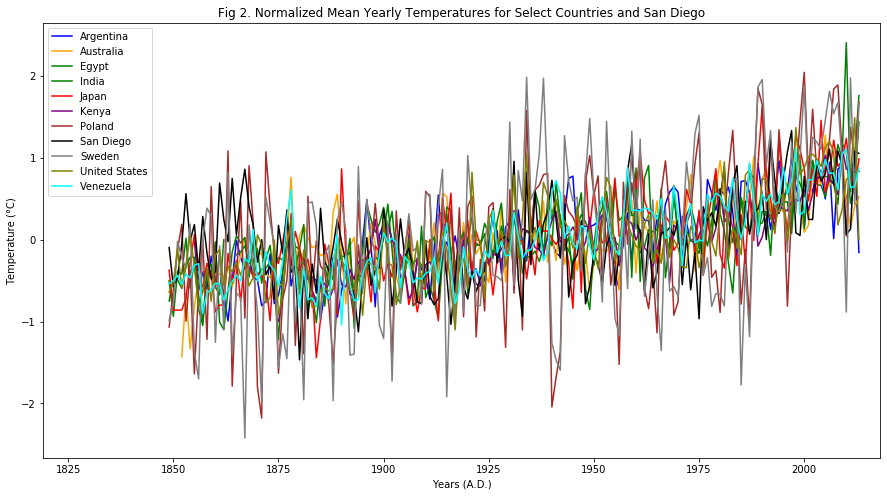

In [16]:
# plot the temperatures for Fig 2
plt.figure(figsize=(15, 8))
plt.plot(year_axis, Argentina_avg_temp_axis, color="blue", label="Argentina")
plt.plot(year_axis, Australia_avg_temp_axis, color="orange", label="Australia")
plt.plot(year_axis, Egypt_avg_temp_axis, color="green", label="Egypt")
plt.plot(year_axis, India_avg_temp_axis, color="green", label="India")
plt.plot(year_axis, Japan_avg_temp_axis, color="red", label="Japan")
plt.plot(year_axis, Kenya_avg_temp_axis, color="purple", label="Kenya")
plt.plot(year_axis, Poland_avg_temp_axis, color="brown", label="Poland")
plt.plot(year_axis, San_Diego_avg_temp_axis, color="black", label="San Diego")
plt.plot(year_axis, Sweden_avg_temp_axis, color="gray", label="Sweden")
plt.plot(year_axis, United_States_avg_temp_axis, color="olive", label="United States")
plt.plot(year_axis, Venezuela_avg_temp_axis, color="cyan", label="Venezuela")

# Place a legend on the chart in what matplotlib believes to be the "best" location
plt.legend(loc="best")

# move the graph to the left to make room for the legend
plt.xlim(beginning_year - 30, ending_year + 5)

plt.title("Fig 2. Normalized Mean Yearly Temperatures for Select Countries and San Diego")
plt.xlabel("Years (A.D.)")
plt.ylabel("Temperature (°C)")

# Save the Figure
plt.savefig("images/Fig 2.png")

### The above figure is too noisy. So only two lines will be drawn, San Diego and the average of the normalized countries.

In [17]:
# calculate the series that is the average of the normalized country temperatures.

# first, replace NaN's with zero. This is necessary because the below country_avg_temp_axis will return
# NaN for any row in which any country temp is a NaN
Argentina_avg_temp_axis[np.isnan(Argentina_avg_temp_axis)] = 0
Australia_avg_temp_axis[np.isnan(Australia_avg_temp_axis)] = 0
Egypt_avg_temp_axis[np.isnan(Egypt_avg_temp_axis)] = 0
India_avg_temp_axis[np.isnan(India_avg_temp_axis)] = 0
Japan_avg_temp_axis[np.isnan(Japan_avg_temp_axis)] = 0
Kenya_avg_temp_axis[np.isnan(Kenya_avg_temp_axis)] = 0
Poland_avg_temp_axis[np.isnan(Poland_avg_temp_axis)] = 0
Sweden_avg_temp_axis[np.isnan(Sweden_avg_temp_axis)] = 0
United_States_avg_temp_axis[np.isnan(United_States_avg_temp_axis)] = 0
Venezuela_avg_temp_axis[np.isnan(Venezuela_avg_temp_axis)] = 0

# create a series that is the number on non-zero values in the country temperature series
reporting_country_count = temp_yearly_mean_pivot.astype(bool).sum(axis=1)

# create a series that is the sum of the country temps divided by the number on non-zero temps
country_avg_temp_axis = (Argentina_avg_temp_axis \
                         + Australia_avg_temp_axis \
                         + Egypt_avg_temp_axis \
                         + India_avg_temp_axis \
                         + Japan_avg_temp_axis \
                         + Kenya_avg_temp_axis \
                         + Poland_avg_temp_axis \
                         + Sweden_avg_temp_axis \
                         + United_States_avg_temp_axis \
                         + Venezuela_avg_temp_axis ) / reporting_country_count

print(reporting_country_count.loc[:])

Year
1849    11
1850    11
1851    11
1852    11
1853    11
        ..
2009    11
2010    11
2011    11
2012    11
2013    11
Length: 165, dtype: int64


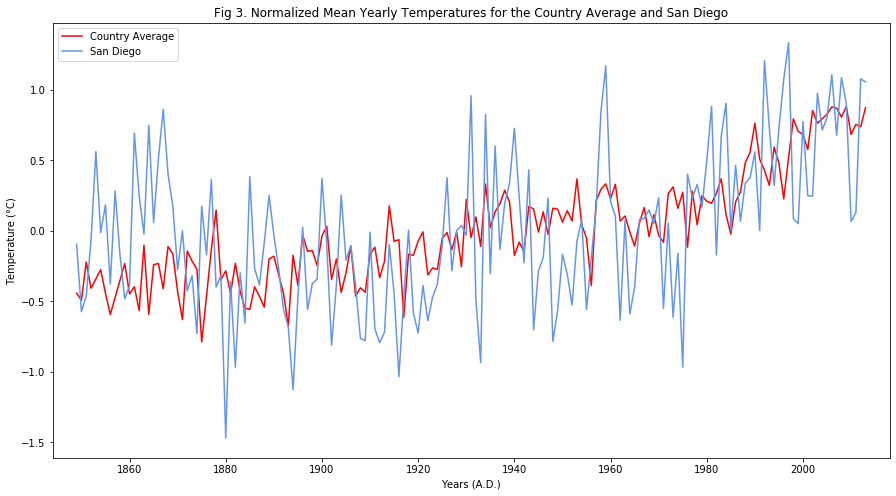

In [18]:
# plot the temperatures for Fig 3
plt.figure(figsize=(15, 8))
plt.plot(year_axis, country_avg_temp_axis, color="red", label="Country Average")
plt.plot(year_axis, San_Diego_avg_temp_axis, color="cornflowerblue", label="San Diego")

# Place a legend on the chart in what matplotlib believes to be the "best" location
plt.legend(loc="best")

# move the graph to the left to make room for the legend
plt.xlim(beginning_year - 5, ending_year + 5)

plt.title("Fig 3. Normalized Mean Yearly Temperatures for the Country Average and San Diego")
plt.xlabel("Years (A.D.)")
plt.ylabel("Temperature (°C)")

# Save the Figure
plt.savefig("images/Fig 3.png")

### The above figure is still too noisy, so use a rolling average to smooth the temperature data.

In [19]:
# the window size will be 10.  The rolling average will be calculated over 10 years.
window = 10

# Before calculating the rolling average, identity the type of country average and San Diego temperature objects.
# If they are different, then different rolling average techniques are used
print(f"The country_avg_temp_axis is a {type(country_avg_temp_axis)} object")
print(f"The Sam_Diego_avg_temp_axis is a {type(San_Diego_avg_temp_axis)} object")

The country_avg_temp_axis is a <class 'pandas.core.series.Series'> object
The Sam_Diego_avg_temp_axis is a <class 'numpy.ndarray'> object


In [20]:
# convert the San_Diego_avg_temp_axis numpy array into a Pandas Series object, so that the same rolling average 
# technique is used on the two temperature objects
San_Diego_avg_temp_axis = pd.Series(San_Diego_avg_temp_axis, year_axis)

In [21]:
# calculate the rolling averages for the two Pandas Series objects

# The Pandas Series.rolling() function provides rolling window calculations over the underlying data in 
# the given Series object.
country_rolling_temp_axis = country_avg_temp_axis.rolling(window).sum() / window
San_Diego_rolling_temp_axis = San_Diego_avg_temp_axis.rolling(window).sum() / window

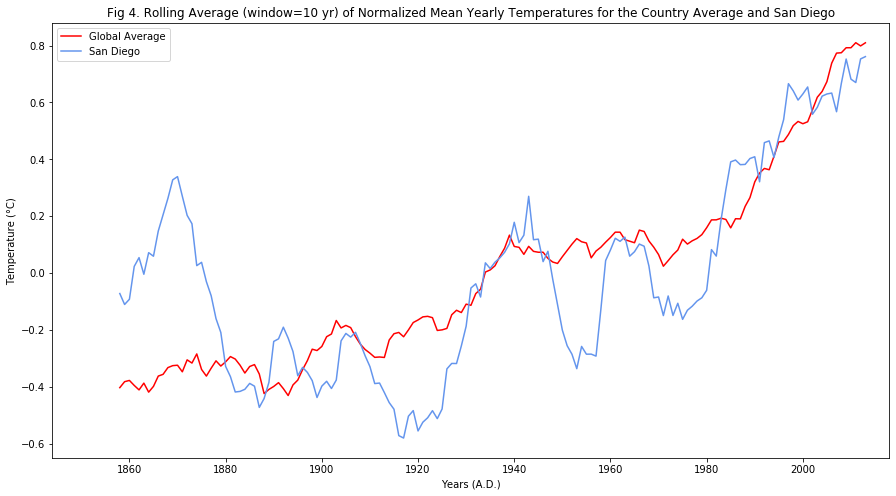

In [22]:
# plot the temperatures for Fig 4
plt.figure(figsize=(15, 8))
plt.plot(year_axis, country_rolling_temp_axis, color="red", label="Global Average")
plt.plot(year_axis, San_Diego_rolling_temp_axis, color="cornflowerblue", label="San Diego")

# Place a legend on the chart in what matplotlib believes to be the "best" location
plt.legend(loc="best")

# move the graph to the left to make room for the legend
plt.xlim(beginning_year - 5, ending_year + 5)

plt.title("Fig 4. Rolling Average (window=10 yr) of Normalized Mean Yearly Temperatures for the Country Average and San Diego")
plt.xlabel("Years (A.D.)")
plt.ylabel("Temperature (°C)")

# Save the Figure
plt.savefig("images/Fig 4.png")

In [23]:
# Set linear regression line for global temps
slope_g, intercept_g, r_value_g, p_value_g, std_err_g = \
    linregress(year_axis, country_avg_temp_axis)
fit_g = slope_g * year_axis + intercept_g

# Set linear regression line for San Diego temps
slope_sd, intercept_sd, r_value_sd, p_value_sd, std_err_sd = \
    linregress(year_axis, San_Diego_avg_temp_axis)
fit_sd = slope_sd * year_axis + intercept_sd

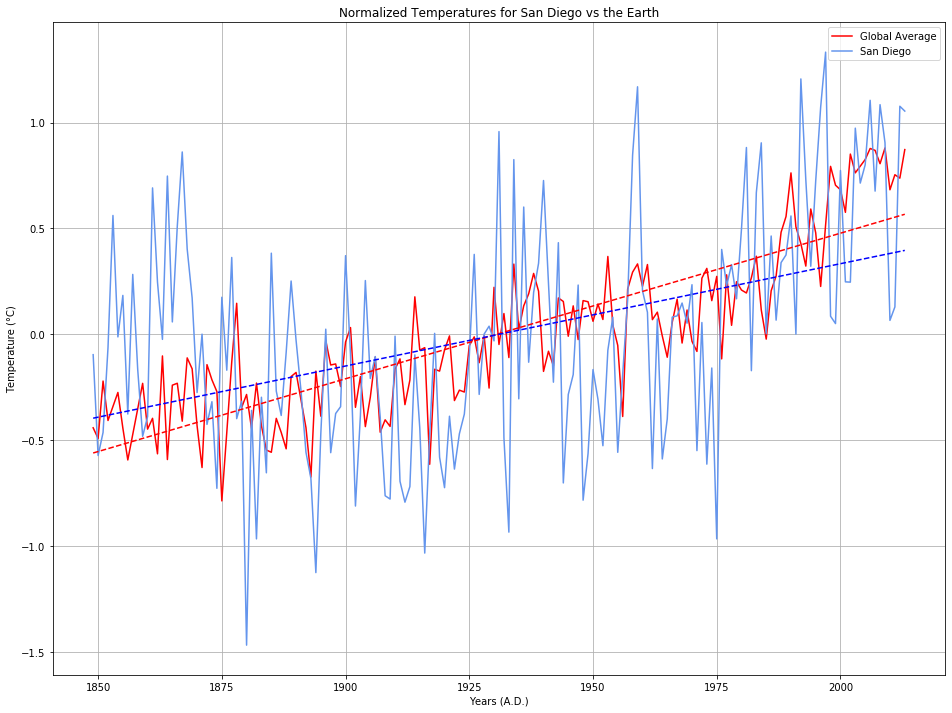

In [24]:
# plot the temperatures for Fig 5
# plot the temperatures as a scatterplot
plt.figure(num=0,figsize=(16, 12))
plt.plot(year_axis, country_avg_temp_axis, color="red", label="Global Average")
plt.plot(year_axis, San_Diego_avg_temp_axis, color="cornflowerblue", label="San Diego")

# plot the linear regression lines 
plt.plot(year_axis, fit_g, 'r--')
plt.plot(year_axis, fit_sd, 'b--')

plt.title("Normalized Temperatures for San Diego vs the Earth")
plt.xlabel("Years (A.D.)")
plt.ylabel("Temperature (°C)")
# plt.tight_layout()
plt.grid()

# Place a legend on the chart in what matplotlib believes to be the "best" location
plt.legend(loc="best")

# Save the Figure
plt.savefig("images/Normalized Temperatures for San Diego vs the Earth.png")

plt.show()

In [25]:
#individual ttest for both San Diego and global mean temperature
combined_df = pd.DataFrame({'local temperature series':San_Diego_avg_temp_axis.values, 
                            'global temperature series':country_avg_temp_axis.values})
combined_df.corr()

,local temperature series,global temperature series
local temperature series,1.000000,0.497691
global temperature series,0.497691,1.000000
